1 : Time-series analysis of instantaneous ENMO and Integrated ENMO analysis: fixed-window and sliding-window approaches

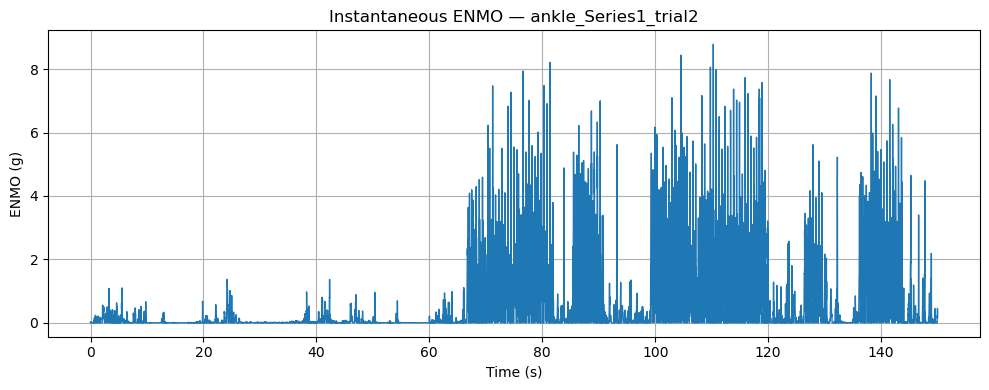

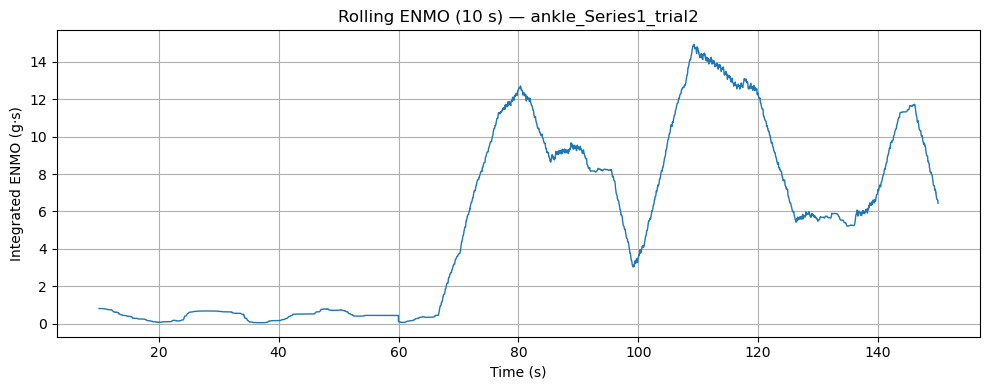

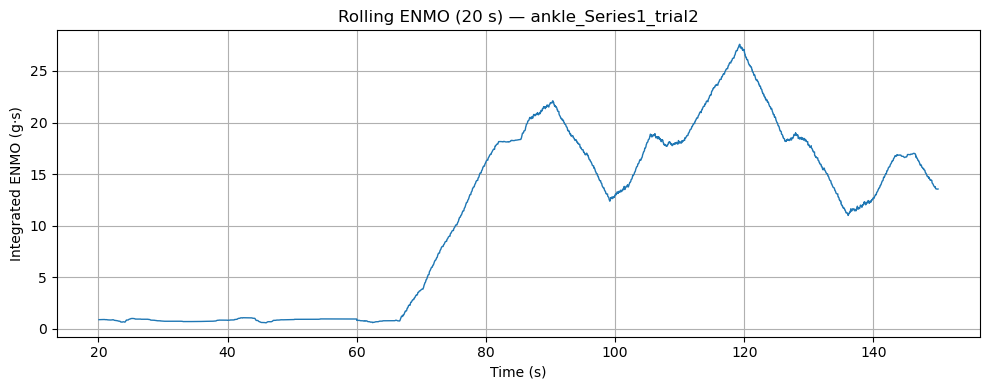

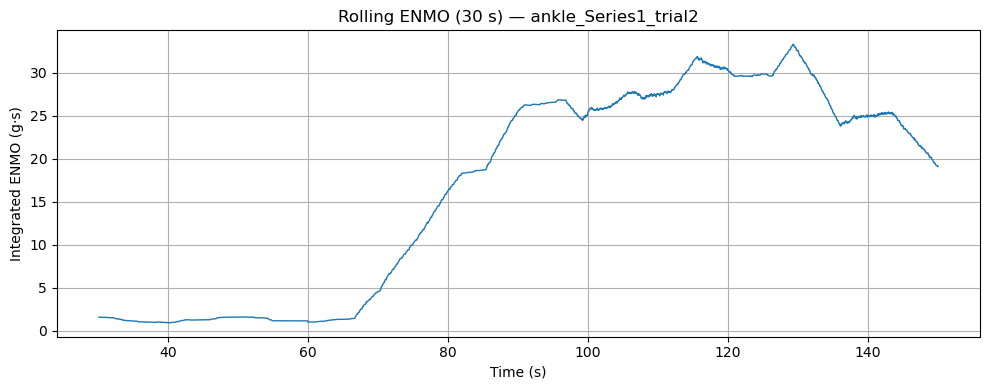

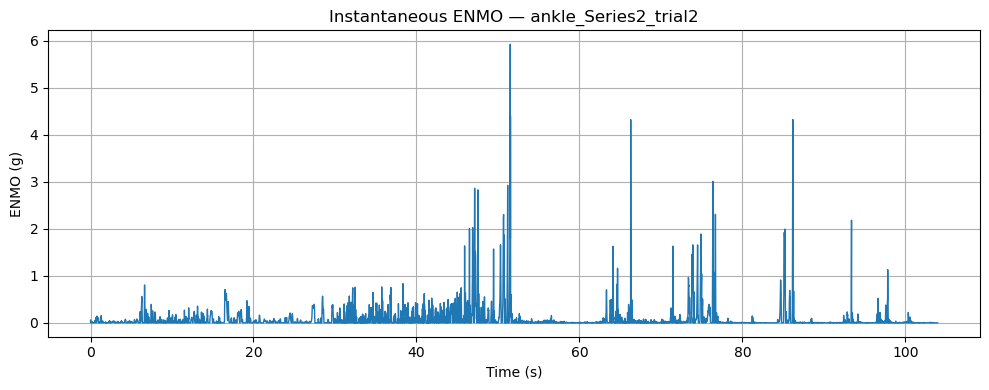

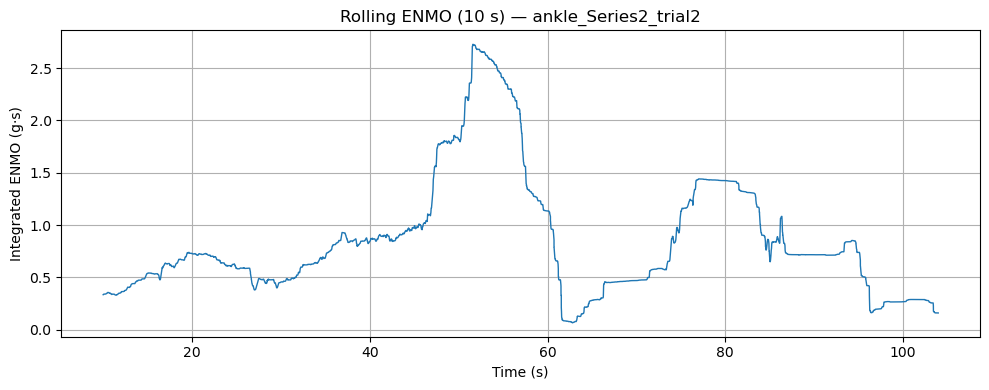

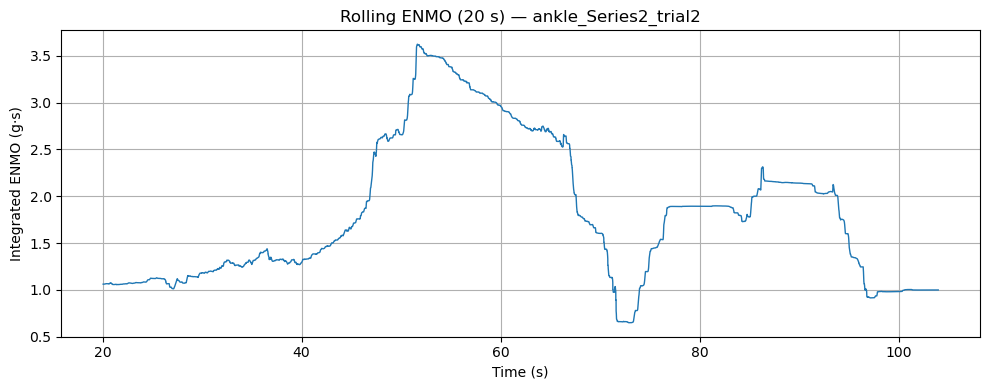

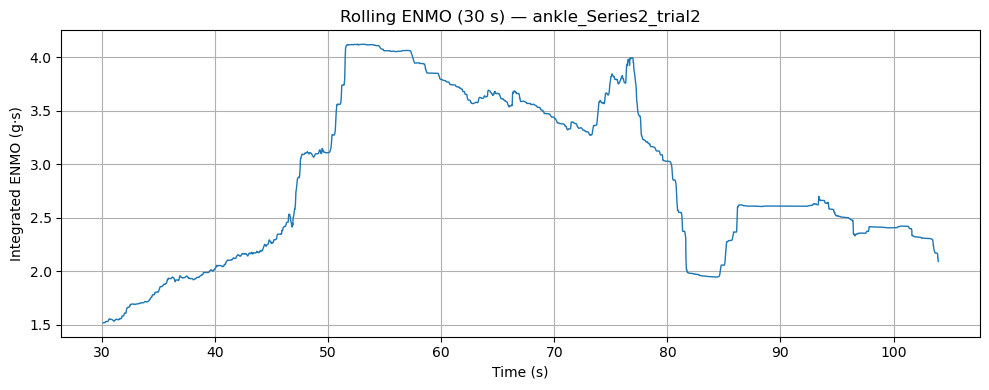

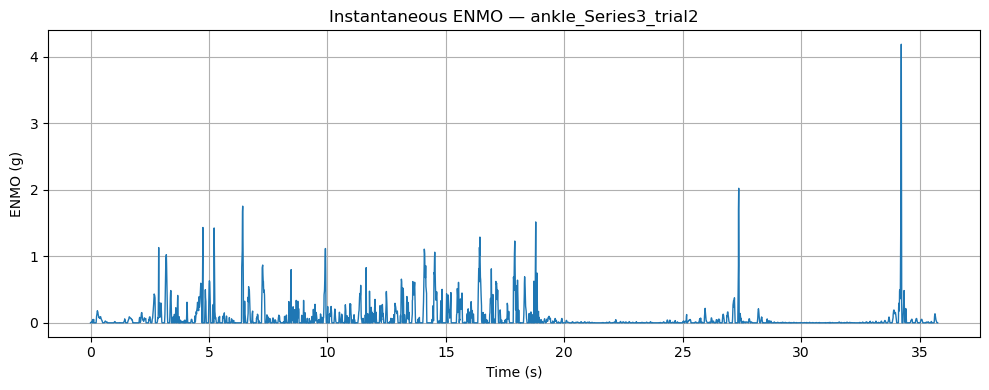

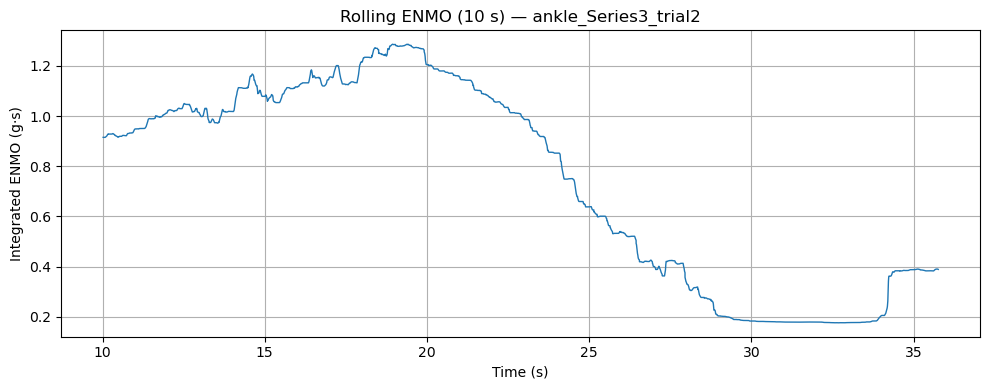

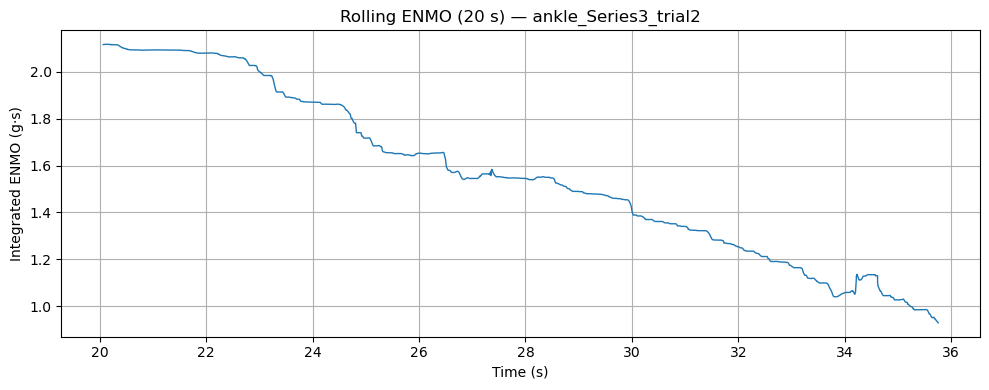

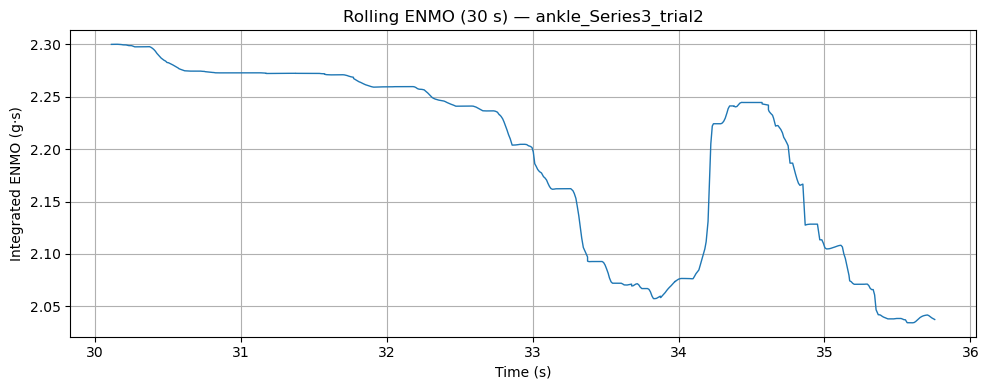

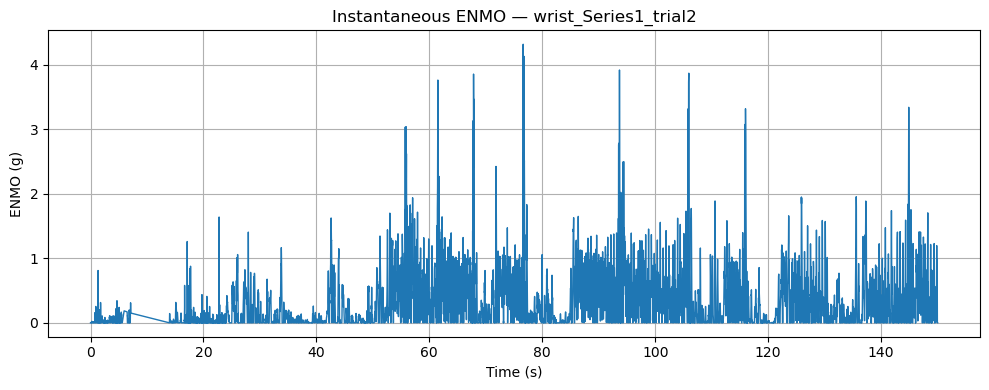

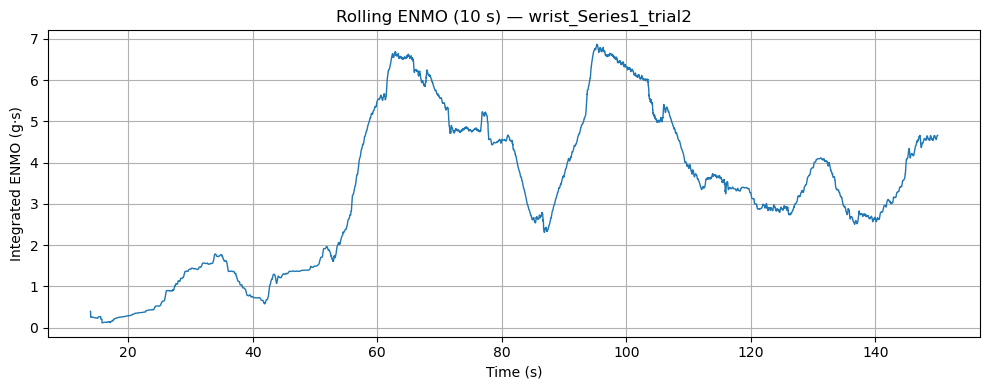

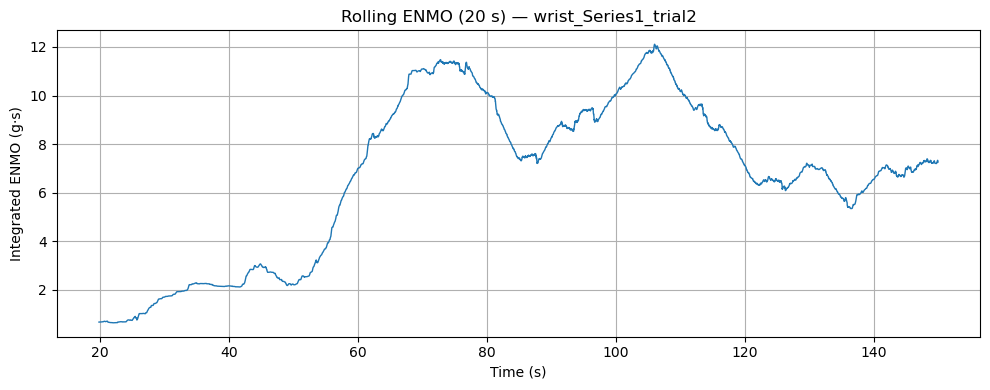

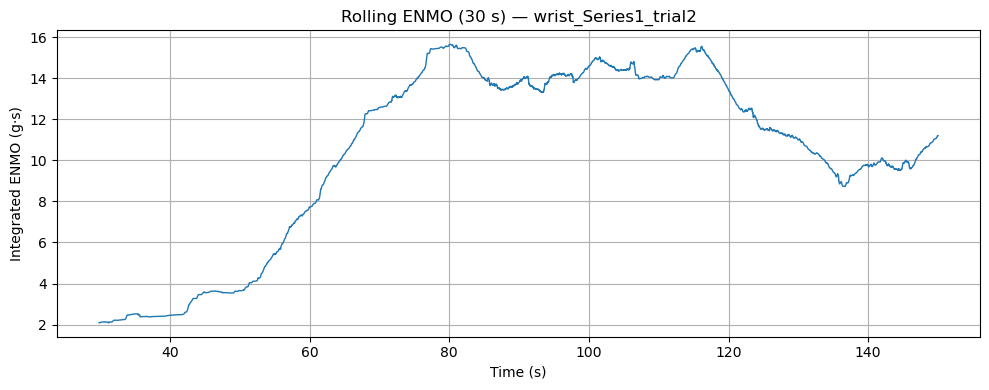

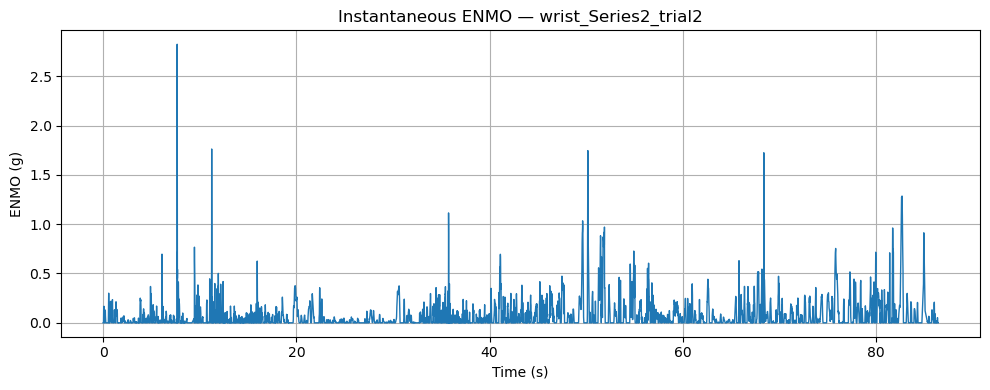

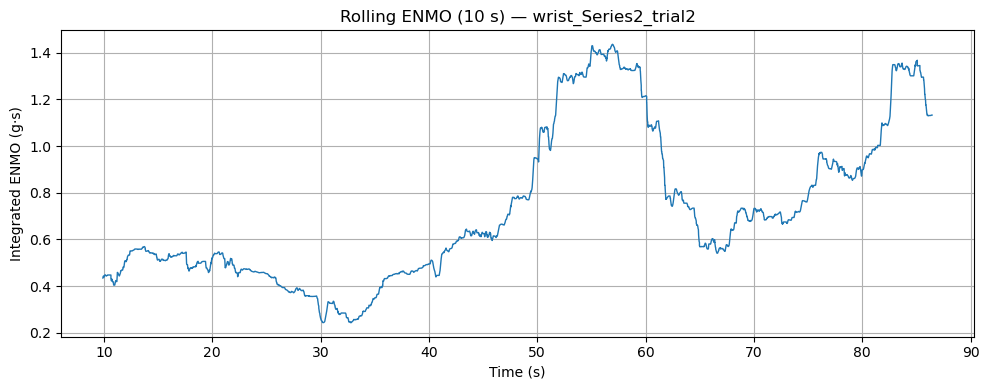

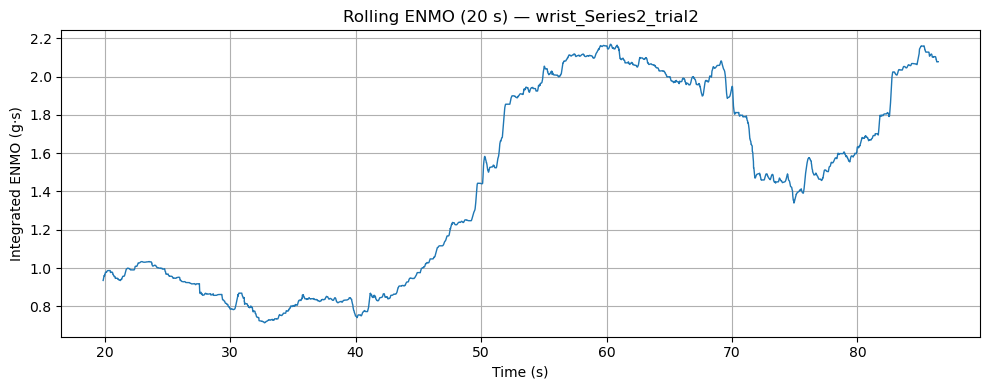

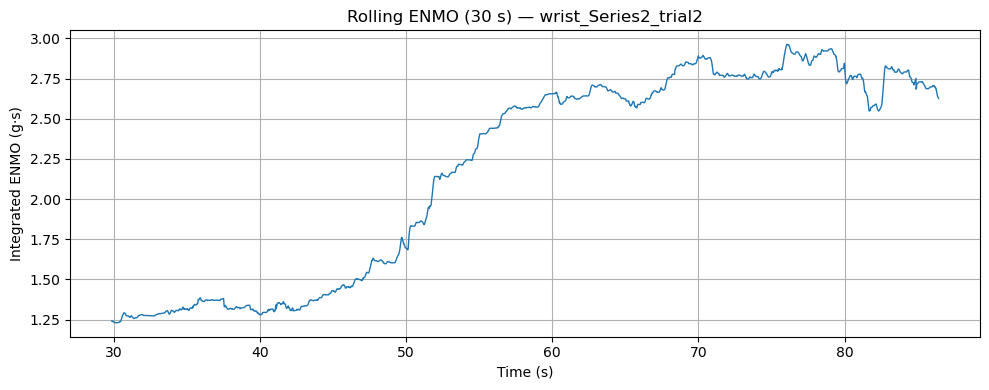

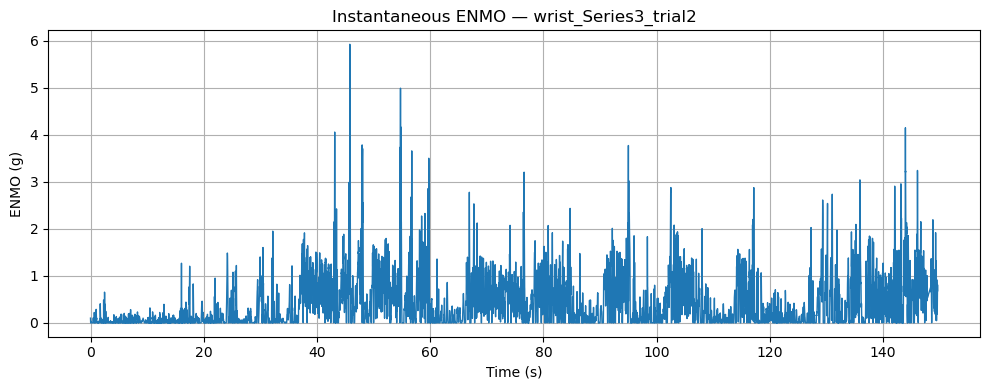

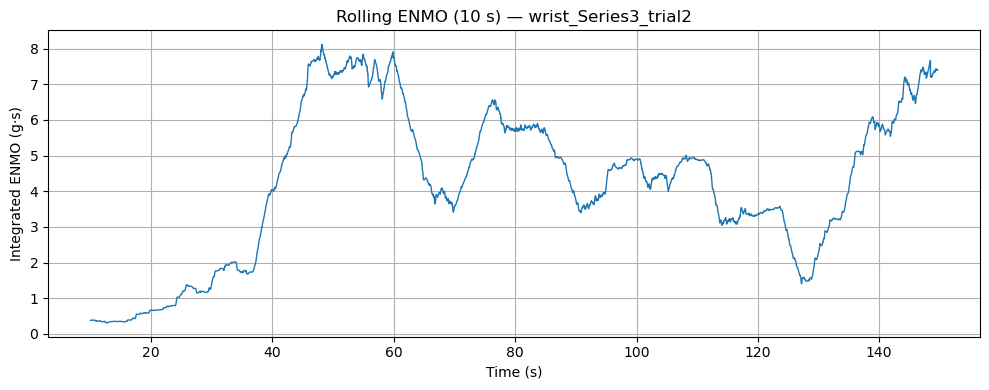

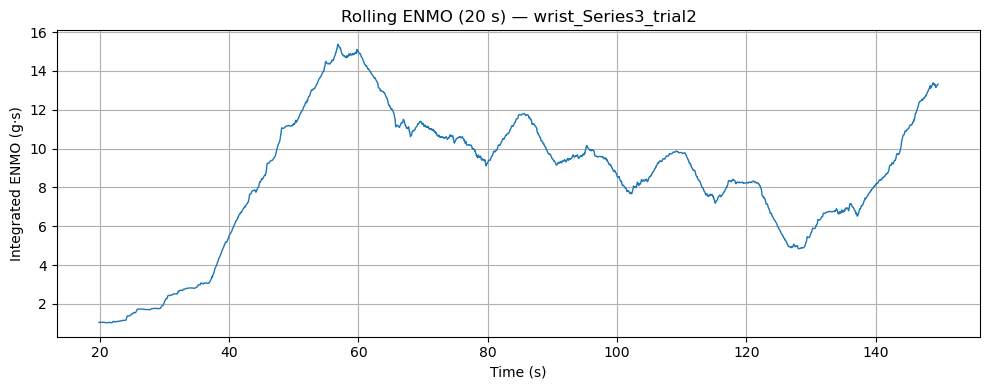

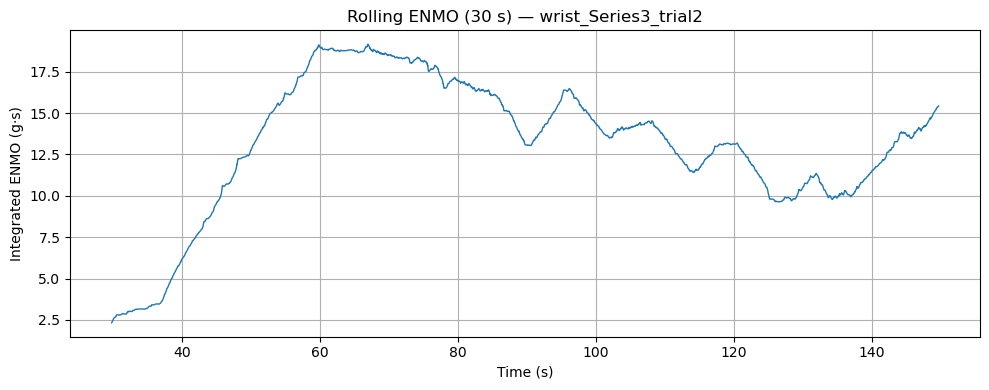

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


# ----------------------------------------------------------------------
# Utility function: ENMO integration using FIXED windows (10, 20, 30 s)
# ----------------------------------------------------------------------
def integrate_enmo_fixed_windows(df, t_col, enmo_col="ENMO", windows=(10, 20, 30)):
    """
    df       : DataFrame containing time (t_col) and ENMO (enmo_col)
    t_col    : column name with time in seconds (e.g., 't_seconds')
    enmo_col : column name with ENMO values
    windows  : integration durations (in seconds)

    Returns a dict {L: DataFrame} with columns:
        - 't_center' : time at the center of each window
        - 'ENMO_int' : integrated ENMO (g·s)
    """
    df = df.copy()

    # Compute dt between samples (can vary)
    dt_series = df[t_col].diff()
    dt_med = dt_series.median()
    df["dt"] = dt_series.fillna(dt_med).clip(lower=0)
    df["ENMO_dt"] = df[enmo_col] * df["dt"]

    results = {}
    for L in windows:
        bin_col = f"bin_{L}s"
        df[bin_col] = (df[t_col] // L).astype(int)

        agg = (
            df.groupby(bin_col)["ENMO_dt"]
            .sum()
            .reset_index()
            .rename(columns={"ENMO_dt": "ENMO_int"})
        )

        agg["t_center"] = (agg[bin_col] + 0.5) * L
        results[L] = agg[["t_center", "ENMO_int"]]

    return results


# ----------------------------------------------------------------------
# TRIAL 2
# ----------------------------------------------------------------------
def analyse_trial2(base_name):
    path = f"data/{base_name}.csv"
    df = pd.read_csv(
        path,
        header=0,
        names=["time", "gFx", "gFy", "gFz", "norm_device"],
        sep=",",
        engine="python",
    )

    # --- Time parsing ---
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df.dropna(subset=["time"]).reset_index(drop=True)

    # --- Numeric accelerations ---
    for c in ["gFx", "gFy", "gFz"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["gFx", "gFy", "gFz"]).reset_index(drop=True)

    # --- ENMO ---
    df["norm"] = np.sqrt(df["gFx"]**2 + df["gFy"]**2 + df["gFz"]**2)
    df["ENMO"] = np.maximum(df["norm"] - 1.0, 0)

    # --- Relative time ---
    t0 = df["time"].iloc[0]
    df["t_seconds"] = (df["time"] - t0).dt.total_seconds()

    # KEEP ONLY FIRST 150 seconds
    df = df[df["t_seconds"] <= 150].reset_index(drop=True)

    # dt
    dt_series = df["t_seconds"].diff()
    dt_med = dt_series.median()
    df["dt"] = dt_series.fillna(dt_med).clip(lower=0)

    df["ENMO_dt"] = df["ENMO"] * df["dt"]

    # Rolling windows
    window_10 = max(int(round(10 / dt_med)), 1)
    window_20 = max(int(round(20 / dt_med)), 1)
    window_30 = max(int(round(30 / dt_med)), 1)

    df["ENMO_10s_rolling"] = df["ENMO_dt"].rolling(window_10).sum()
    df["ENMO_20s_rolling"] = df["ENMO_dt"].rolling(window_20).sum()
    df["ENMO_30s_rolling"] = df["ENMO_dt"].rolling(window_30).sum()

    # Fixed windows
    integrals = integrate_enmo_fixed_windows(df, "t_seconds", "ENMO", (10, 20, 30))

    os.makedirs("resultats", exist_ok=True)

    # Plots
    plt.figure(figsize=(10, 4))
    plt.plot(df["t_seconds"], df["ENMO"], linewidth=1)
    plt.xlabel("Time (s)")
    plt.ylabel("ENMO (g)")
    plt.title(f"Instantaneous ENMO — {base_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"resultats/{base_name}_ENMO_Trial2.png", dpi=200)
    plt.show()
    plt.close()

    # Rolling
    plt.figure(figsize=(10, 4))
    plt.plot(df["t_seconds"], df["ENMO_10s_rolling"], linewidth=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Integrated ENMO (g·s)")
    plt.title(f"Rolling ENMO (10 s) — {base_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"resultats/{base_name}_ENMO10s_rolling_Trial2.png", dpi=200)
    plt.show()
    plt.close()

    plt.figure(figsize=(10, 4))
    plt.plot(df["t_seconds"], df["ENMO_20s_rolling"], linewidth=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Integrated ENMO (g·s)")
    plt.title(f"Rolling ENMO (20 s) — {base_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"resultats/{base_name}_ENMO20s_rolling_Trial2.png", dpi=200)
    plt.show()
    plt.close()

    plt.figure(figsize=(10, 4))
    plt.plot(df["t_seconds"], df["ENMO_30s_rolling"], linewidth=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Integrated ENMO (g·s)")
    plt.title(f"Rolling ENMO (30 s) — {base_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"resultats/{base_name}_ENMO30s_rolling_Trial2.png", dpi=200)
    plt.show()
    plt.close()

    # Fixed
    for L in (10, 20, 30):
        agg = integrals[L]
        plt.figure(figsize=(10, 4))
        plt.plot(agg["t_center"], agg["ENMO_int"], marker="o", linewidth=1)
        plt.xlabel("Time (s)")
        plt.ylabel("Integrated ENMO (g·s)")
        plt.title(f"Integrated ENMO over {L} s — {base_name}")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"resultats/{base_name}_ENMO{L}s_fixed_Trial2.png", dpi=200)
        plt.close()

# ----------------------------------------------------------------------
# MAIN
# ----------------------------------------------------------------------
if __name__ == "__main__":

    trial2_files = [
        "ankle_Series1_trial2",
        "ankle_Series2_trial2",
        "ankle_Series3_trial2",
        "wrist_Series1_trial2",
        "wrist_Series2_trial2",
        "wrist_Series3_trial2",
    ]

    for f in trial2_files:
        analyse_trial2(f)

2 : Boxplot comparison of series 1–3 between ankle and wrist

BASE_DIR    : C:\Users\lucie\Documents\Mon nuage\Cours Fac\Master 2 SNS\HAH913E_activité_physique\accelerometer\HAH913E-2025-accelerometer
DATA_DIR    : C:\Users\lucie\Documents\Mon nuage\Cours Fac\Master 2 SNS\HAH913E_activité_physique\accelerometer\HAH913E-2025-accelerometer\data
RESULTS_DIR : C:\Users\lucie\Documents\Mon nuage\Cours Fac\Master 2 SNS\HAH913E_activité_physique\accelerometer\HAH913E-2025-accelerometer\resultats

 Comparative ankle vs wrist boxplots (TRIAL 2 ONLY)

Reading file: ankle_Series1_trial2.csv

Reading file: wrist_Series1_trial2.csv


C:\Users\lucie\AppData\Local\Temp\ipykernel_13388\1634595314.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lucie\AppData\Local\Temp\ipykernel_13388\1634595314.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


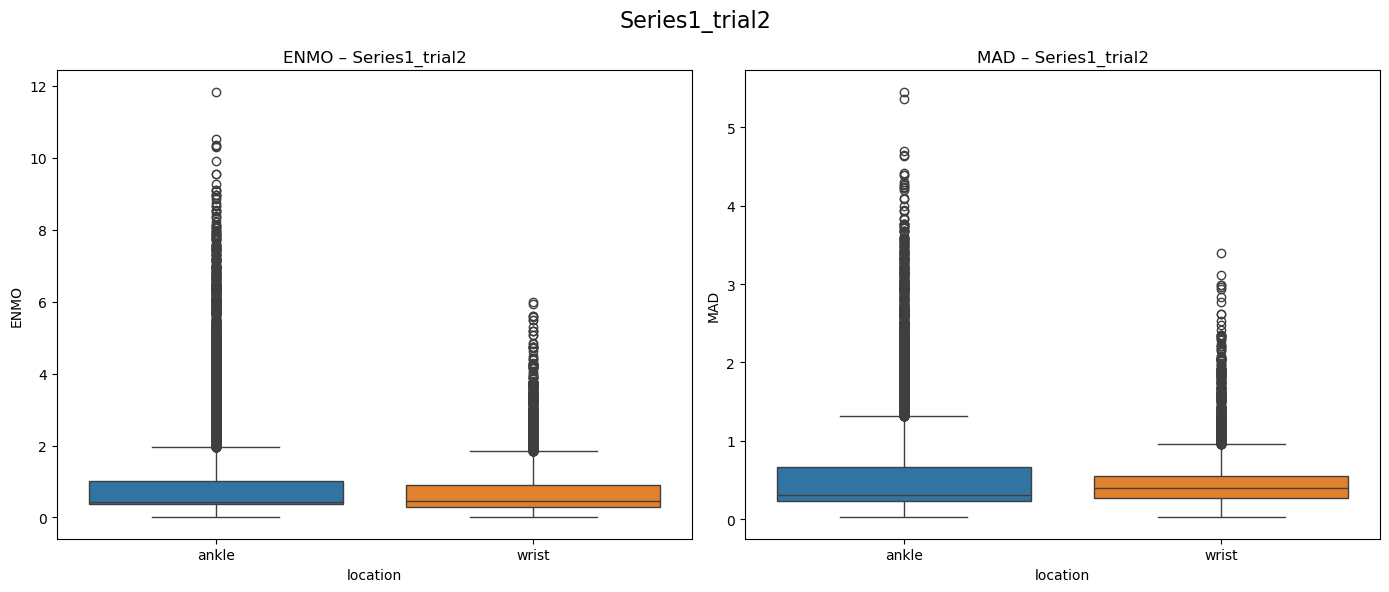

Ankle vs wrist figure saved: C:\Users\lucie\Documents\Mon nuage\Cours Fac\Master 2 SNS\HAH913E_activité_physique\accelerometer\HAH913E-2025-accelerometer\resultats\Series1_trial2_ankle_vs_wrist.png
Comparison generated for Series1_trial2
--------------------------------------------

Reading file: ankle_Series2_trial2.csv

Reading file: wrist_Series2_trial2.csv


C:\Users\lucie\AppData\Local\Temp\ipykernel_13388\1634595314.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lucie\AppData\Local\Temp\ipykernel_13388\1634595314.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


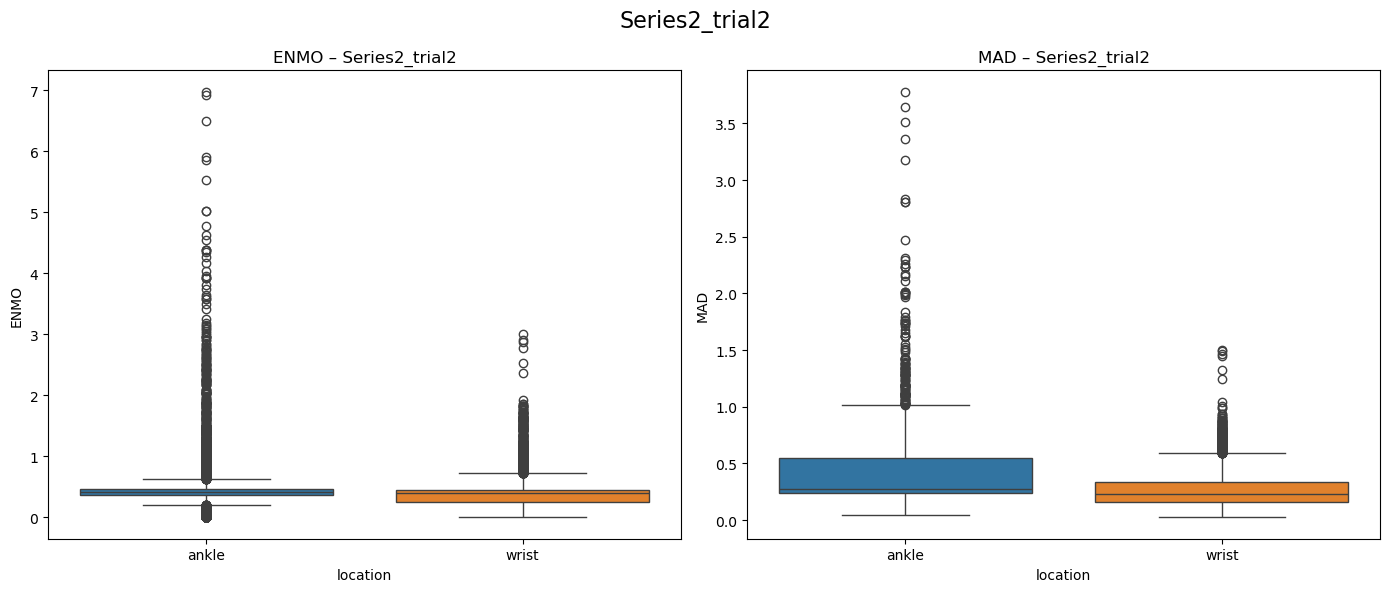

Ankle vs wrist figure saved: C:\Users\lucie\Documents\Mon nuage\Cours Fac\Master 2 SNS\HAH913E_activité_physique\accelerometer\HAH913E-2025-accelerometer\resultats\Series2_trial2_ankle_vs_wrist.png
Comparison generated for Series2_trial2
--------------------------------------------

Reading file: ankle_Series3_trial2.csv

Reading file: wrist_Series3_trial2.csv


C:\Users\lucie\AppData\Local\Temp\ipykernel_13388\1634595314.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lucie\AppData\Local\Temp\ipykernel_13388\1634595314.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


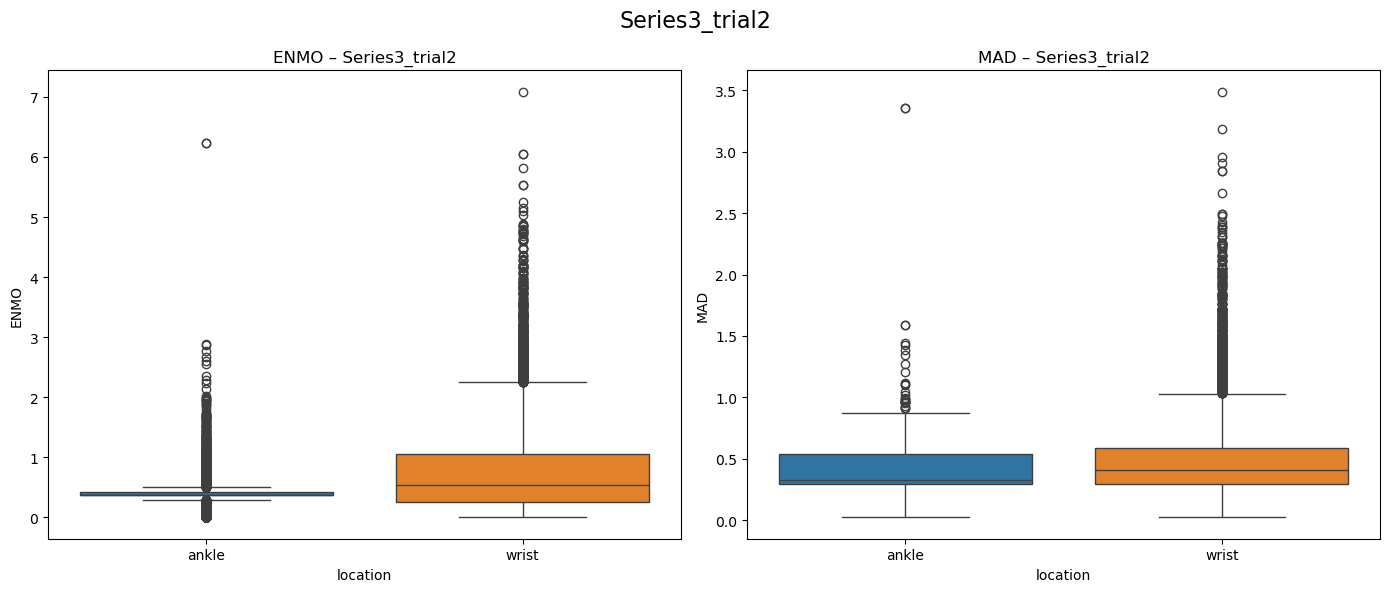

Ankle vs wrist figure saved: C:\Users\lucie\Documents\Mon nuage\Cours Fac\Master 2 SNS\HAH913E_activité_physique\accelerometer\HAH913E-2025-accelerometer\resultats\Series3_trial2_ankle_vs_wrist.png
Comparison generated for Series3_trial2
--------------------------------------------

All comparative TRIAL 2 boxplots have been generated.


In [3]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Base directory: current working directory of the notebook/script
BASE_DIR = Path().resolve()

# Folder where your CSV files are stored
DATA_DIR = BASE_DIR / "data"

# Folder where all figures will be saved
RESULTS_DIR = BASE_DIR / "resultats"
os.makedirs(RESULTS_DIR, exist_ok=True)

print("BASE_DIR    :", BASE_DIR)
print("DATA_DIR    :", DATA_DIR)
print("RESULTS_DIR :", RESULTS_DIR)


def read_accel_file_box(file_path: Path):
    """
    Read a raw ankle/wrist CSV file.

    New Trial 2 files have 5 columns, but we only keep
    the first 4: time, X, Y, Z.
    This also works if there are exactly 4 columns.
    """
    print(f"\nReading file: {file_path.name}")

    try:
        df = pd.read_csv(file_path, sep=",", engine="python")
    except Exception as e:
        print(f"Read error: {e}")
        return None

    # Need at least 4 columns
    if df.shape[1] < 4:
        print(f"Not enough columns in {file_path.name} (got {df.shape[1]})")
        return None

    # Keep only the first 4 columns and rename them
    df = df.iloc[:, :4]
    df.columns = ["time", "X", "Y", "Z"]

    # Ensure X, Y, Z are numeric
    for c in ["X", "Y", "Z"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["X", "Y", "Z"]).reset_index(drop=True)

    return df


def compute_metrics_box(df: pd.DataFrame):
    """
    Compute ENMO and MAD from X, Y, Z.

    ENMO:
        ENMO = max(||a|| - 1g, 0)
    MAD:
        Mean Absolute Deviation around the mean, per sample.
    """
    df = df.copy()

    # ENMO
    df["ENMO"] = np.maximum(
        np.sqrt(df["X"]**2 + df["Y"]**2 + df["Z"]**2) - 1, 0
    )

    # MAD: average absolute deviation from the mean of X, Y, Z
    df["MAD"] = (df[["X", "Y", "Z"]] - df[["X", "Y", "Z"]].mean()).abs().mean(axis=1)

    return df


def plot_comparison_box(df_ankle: pd.DataFrame, df_wrist: pd.DataFrame, title: str):
    """
    Create boxplots of ENMO and MAD for ankle vs wrist.

    Saves the figure in the 'resultats' folder as:
        {title}_ankle_vs_wrist.png
    """
    combined = pd.concat(
        [
            pd.DataFrame(
                {
                    "location": "ankle",
                    "ENMO": df_ankle["ENMO"],
                    "MAD": df_ankle["MAD"],
                }
            ),
            pd.DataFrame(
                {
                    "location": "wrist",
                    "ENMO": df_wrist["ENMO"],
                    "MAD": df_wrist["MAD"],
                }
            ),
        ],
        ignore_index=True,
    )

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Explicit palette: ankle = blue, wrist = orange
    palette = {"ankle": "tab:blue", "wrist": "tab:orange"}
    order = ["ankle", "wrist"]

    # ENMO boxplot
    sns.boxplot(
        ax=axes[0],
        data=combined,
        x="location",
        y="ENMO",
        order=order,
        palette=palette,
    )
    axes[0].set_title(f"ENMO – {title}")

    # MAD boxplot
    sns.boxplot(
        ax=axes[1],
        data=combined,
        x="location",
        y="MAD",
        order=order,
        palette=palette,
    )
    axes[1].set_title(f"MAD – {title}")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()

    out_path = RESULTS_DIR / f"{title}_ankle_vs_wrist.png"
    fig.savefig(out_path, dpi=300)

    # Show in notebook / window, then close
    plt.show()
    plt.close(fig)

    print(f"Ankle vs wrist figure saved: {out_path}")


print("\n==============================")
print(" Comparative ankle vs wrist boxplots (TRIAL 2 ONLY)")
print("==============================")

comparisons = [
    ("Series1_trial2", "ankle_Series1_trial2.csv", "wrist_Series1_trial2.csv"),
    ("Series2_trial2", "ankle_Series2_trial2.csv", "wrist_Series2_trial2.csv"),
    ("Series3_trial2", "ankle_Series3_trial2.csv", "wrist_Series3_trial2.csv"),
]

for label, ankle_file, wrist_file in comparisons:
    path_ankle = DATA_DIR / ankle_file
    path_wrist = DATA_DIR / wrist_file

    df_ankle = read_accel_file_box(path_ankle)
    df_wrist = read_accel_file_box(path_wrist)

    if df_ankle is None or df_wrist is None:
        print(f"Not enough data for {label}. Skipping.")
        print("--------------------------------------------")
        continue

    df_ankle = compute_metrics_box(df_ankle)
    df_wrist = compute_metrics_box(df_wrist)

    plot_comparison_box(df_ankle, df_wrist, label)
    print(f"Comparison generated for {label}")
    print("--------------------------------------------")

print("\nAll comparative TRIAL 2 boxplots have been generated.")
